# Import libraries and read data

In [1]:
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
from time import time
from pandas import DataFrame, concat
from seaborn import lineplot
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import torch
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from lightning import Trainer
from lightning.pytorch.loggers import CSVLogger
from ideal_init.lightning_model import RNNClassifier, merge_logs

# Define training parameters
BATCH_SIZE = 2**10
LEARNING_RATE = 1e-2
DIRECTORY = "./"
EPOCHS = 10

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
tokenizer = get_tokenizer("spacy")
embedding_function = GloVe(name="42B", dim=300)
def text_embedding(words):
    embeddings = [embedding_function[word] for word in words]
    embeddings = torch.stack(embeddings)
    return embeddings

def text_data(subset):
    texts, labels = fetch_20newsgroups(return_X_y=True, subset=subset, remove=("headers", "footers", "quotes"), categories=categories)
    X = []
    y = []
    max_len = 300
    for label, text in zip(labels, texts):
        try:
            tokens = tokenizer(text.lower())
            if len(tokens) > max_len:
                tokens = tokens[:max_len]
            X.append(text_embedding(tokens))
            y.append(label)
        except:
            continue
    X = pad_sequence(X, batch_first=True)
    y = torch.tensor(y)
    return X, y

def experiment_data():
    X_train, y_train = text_data("train")
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
    X_test, y_test = text_data("test")
    return X_train, y_train, X_val, y_val, X_test, y_test

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


# Run experiments and measure performance

Running experiment 1
Running experiment 2
Running experiment 3
Running experiment 4
Running experiment 5
Running experiment 6
Running experiment 7
Running experiment 8
Mean values:
IDEAL_acc_before_train    0.2360
IDEAL_acc_after_train     0.2888
IDEAL_init_time           1.8138
IDEAL_train_time          67.071
He_acc_before_train       0.2187
He_acc_after_train        0.2928
He_init_time              0.0015
He_train_time             67.092
dtype: object
Confidence error:
IDEAL_acc_before_train       0.0
IDEAL_acc_after_train        0.0
IDEAL_init_time           0.0629
IDEAL_train_time          9.9410
He_acc_before_train       0.0256
He_acc_after_train        0.0042
He_init_time              2.6930
He_train_time             9.8843
dtype: object


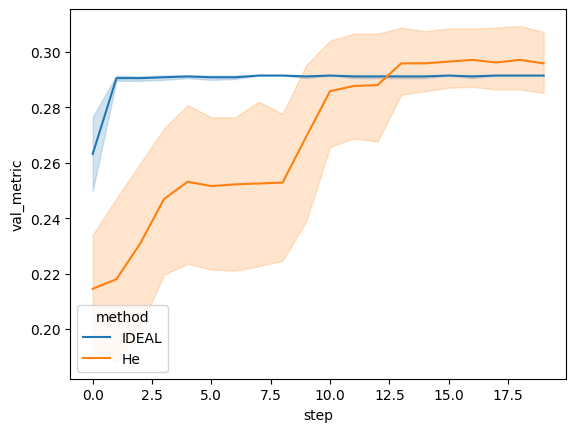

In [2]:
# keep record of the results of all the iterations
values=["IDEAL_acc_before_train", "IDEAL_acc_after_train", "IDEAL_init_time", "IDEAL_train_time", "He_acc_before_train", "He_acc_after_train", "He_init_time", "He_train_time"]
results = {value: [] for value in values}
all_logs = DataFrame()

# repeat experiment multiple times
NUM_EXPERIMENTS = 10
for experiment in range(NUM_EXPERIMENTS):

    print(f"Running experiment {experiment+1}")
    X_train, y_train, X_val, y_val, X_test, y_test = experiment_data()

    # Create models
    init_model = RNNClassifier(X_train, y_train, X_val, y_val, X_test, y_test, initialize=True, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
    no_init_model = RNNClassifier(X_train, y_train, X_val, y_val, X_test, y_test, initialize=False, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)

    # Create trainers
    init_trainer = Trainer(default_root_dir=DIRECTORY, accelerator="auto", devices="auto", max_epochs=EPOCHS, logger=CSVLogger(save_dir=DIRECTORY), enable_checkpointing=False, enable_progress_bar=False, enable_model_summary=False, val_check_interval=1, log_every_n_steps=1, limit_val_batches=1, precision=64)
    no_init_trainer = Trainer(default_root_dir=DIRECTORY, accelerator="auto", devices="auto", max_epochs=EPOCHS, logger=CSVLogger(save_dir=DIRECTORY), enable_checkpointing=False, enable_progress_bar=False, enable_model_summary=False, val_check_interval=1, log_every_n_steps=1, limit_val_batches=1, precision=64)

    # Test models before training
    results["IDEAL_acc_before_train"].append(init_trainer.test(init_model, verbose=False)[0]["test_metric"])
    results["He_acc_before_train"].append(no_init_trainer.test(no_init_model, verbose=False)[0]["test_metric"])

    # Train models and plot training comparison
    init_time = time()
    init_trainer.validate(init_model)
    init_trainer.fit(init_model)
    init_time = time() - init_time
    init_model_logs = f"{init_trainer.logger.log_dir}/metrics.csv"

    no_init_time = time()
    no_init_trainer.validate(no_init_model)
    no_init_trainer.fit(no_init_model)
    no_init_time = time() - no_init_time
    no_init_model_logs = f"{no_init_trainer.logger.log_dir}/metrics.csv"

    logs = merge_logs(init_model_logs, no_init_model_logs)

    # Test models after training
    results["IDEAL_acc_after_train"].append(init_trainer.test(init_model, verbose=False)[0]["test_metric"])
    results["He_acc_after_train"].append(no_init_trainer.test(no_init_model, verbose=False)[0]["test_metric"])

    # Init and train times
    results["IDEAL_init_time"].append(init_model.init_time)
    results["IDEAL_train_time"].append(init_time)
    results["He_init_time"].append(no_init_model.init_time)
    results["He_train_time"].append(no_init_time)

    # store logs
    all_logs = concat([all_logs, logs])

    #clear cache
    del init_model, no_init_model
    del init_trainer, no_init_trainer
    del X_train, y_train, X_val, y_val, X_test, y_test
    torch.cuda.empty_cache()

results = DataFrame(results)
mean = results.mean()
error = results.sem()*1.96
print("Mean values:")
print(mean.astype(str).apply(lambda x: x[:6]))
print("Confidence error:")
print(error.astype(str).apply(lambda x: x[:6]))
lineplot(all_logs, x="step", y="val_metric", hue="method");